<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/notebooks/L29-GraphConvolutionalNetworks-NodeClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Convolutional Networks - Node Classification
### Introduction Graph Convolutional Networks

The Graph Convolutional Network (GCN) architecture is the blueprint of what a GNN looks like. Introduced by [Kipf and Welling in 2017](https://arxiv.org/abs/1609.02907), it is based on the idea of creating an efficient variant of **Convolutional Neural Networks (CNNs)** applied to graphs. More accurately, it is an approximation of a graph convolution operation in graph signal processing. Thanks to its versatility and ease of use, the **GCN** has become the most popular GNN in scientific literature. More generally, it is the architecture of choice to create a solid baseline when dealing with graph data.

In [1]:
!pip install torch-geometric
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install pyg_lib --no-index -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 84.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 45.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 23.1 MB/s eta 0:00:00


In [2]:
import torch
# !pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Designing the graph convolutional layer

Unlike tabular or image data, nodes do not always have the same number of neighbors. For instance, node 1 has 3 neighbors while node 2 only has 1.

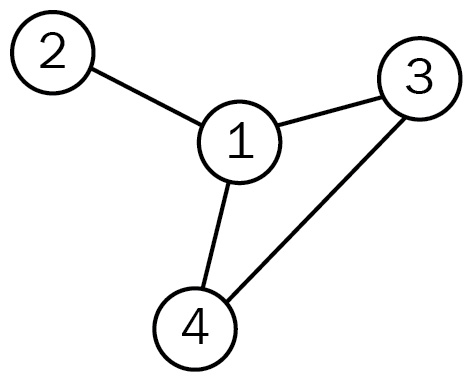


However, if we look at our GNN layer, we don’t take into account this difference in the number of neighbors. Our layer consists of a simple sum without any normalization coefficient. Here is how we calculated the embedding of a node, $i$.

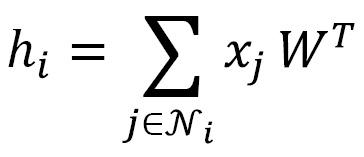



Imagine that node 1 has 1,000 neighbors and node 2 only has 1: the embedding $h_a$ will have much larger values than $h_b$. This is an issue because we want to compare these embeddings. How are we supposed to make meaningful comparisons when their values are so vastly different?


Fortunately, there is a simple solution: dividing the embedding by the number of neighbors. Let’s write $deg(A)$, the degree of node $A$. Here is the new formula for the GNN layer:

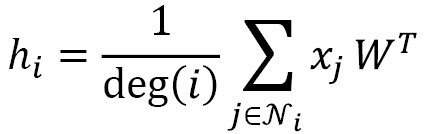

But how do we translate it into a matrix multiplication? As a reminder, this was what we obtained for our vanilla GNN layer:

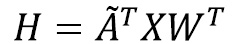

Here, $$\hat{A} = A + I$$

The only thing that is missing from this formula is a matrix to give us the normalization coefficient, $\frac{1}{deg(i)}$. This is something that can be obtained thanks to the degree matrix $D$, which counts the number of neighbors for each node. Here is the degree matrix for the graph shown:

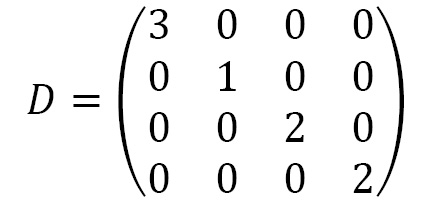

In [3]:
import numpy as np
np.random.seed(0)

D = np.array([
    [3, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 2, 0],
    [0, 0, 0, 2]
])

By definition, $D$ gives us the degree of each node, $deg(i)$. Therefore, the inverse of this matrix $D^{-1}$ directly gives us the normalization coefficients, $\frac{1}{deg(i)}$:

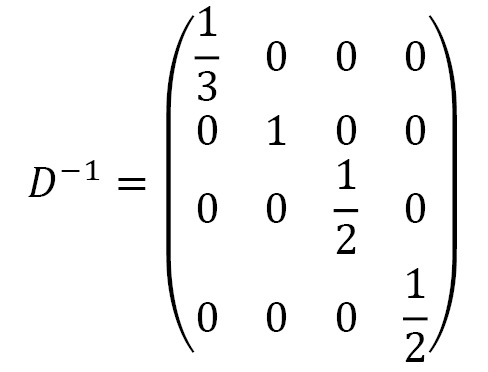

The inverse of a matrix can directly be calculated using the `numpy.linalg.inv()` function:

In [4]:
np.linalg.inv(D)

array([[0.33333333, 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.        , 0.5       ]])

This is exactly what we were looking for. To be even more accurate, we added self-loops to the graph, represented by:

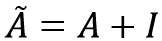

Likewise, we should add self-loops to the degree matrix,

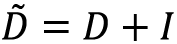

The final matrix we are actually interested in is


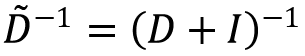:

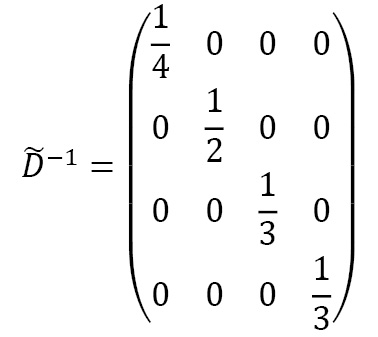

NumPy has a specific function, `numpy.identity(n)`, to quickly create an identity matrix  of  dimensions. In this example, we have four dimensions:

In [5]:
np.linalg.inv(D + np.identity(4))

array([[0.25      , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.        , 0.33333333]])

Now that we have our matrix of normalization coefficients, where should we put it in the formula? There are two options:

- 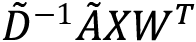
 will normalize every row of features

- 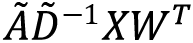
 will normalize every column of features.

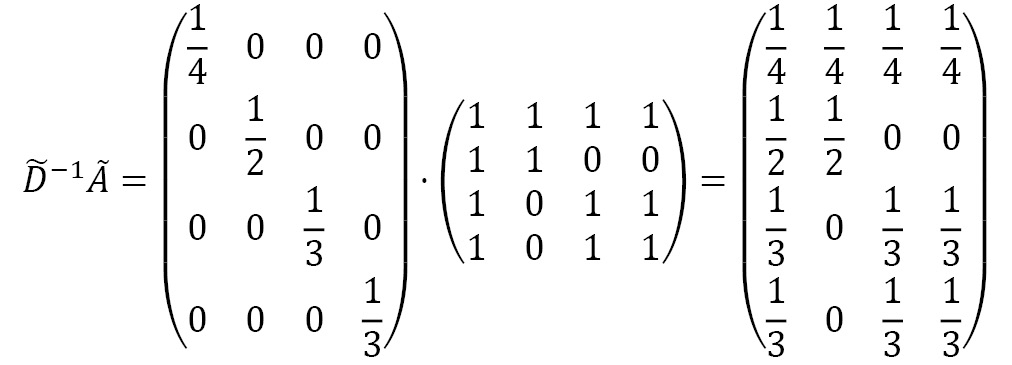

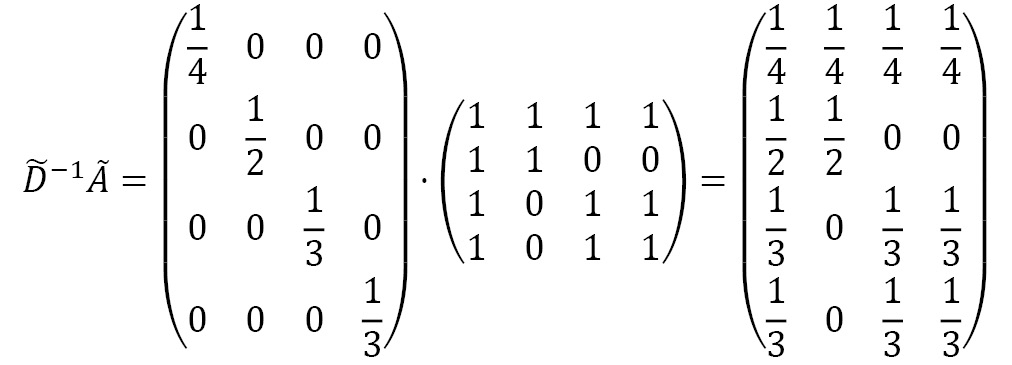

Indeed, in the first case, the sum of every row is equal to 1. In the second case, the sum of every column is equal to 1.

Matrix multiplications can be performed using the `numpy.matmul()` function. Even more conveniently, Python has had its own matrix multiplication operator, `@`, since version 3.5. Let’s define the adjacency matrix $A$ and use this operator to compute our matrix multiplications:

In [6]:
A = np.array([
    [1, 1, 1, 1],
    [1, 1, 0, 0],
    [1, 0, 1, 1],
    [1, 0, 1, 1]
])

print(np.linalg.inv(D + np.identity(4)) @ A)
print()
print(A @ np.linalg.inv(D + np.identity(4)))

[[0.25       0.25       0.25       0.25      ]
 [0.5        0.5        0.         0.        ]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.33333333 0.         0.33333333 0.33333333]]

[[0.25       0.5        0.33333333 0.33333333]
 [0.25       0.5        0.         0.        ]
 [0.25       0.         0.33333333 0.33333333]
 [0.25       0.         0.33333333 0.33333333]]


We obtain the same results as with manual matrix multiplication.

So, which option should we use? Naturally, the first option looks more appealing because it nicely normalizes neighboring node features.

However, [Kipf and Welling](https://arxiv.org/abs/1609.02907) noticed that features from nodes with a lot of neighbors spread very easily, unlike features from more isolated nodes. In the original GCN paper, the authors proposed a hybrid normalization to counterbalance this effect. In practice, they assign higher weights to nodes with few neighbors using the following formula:

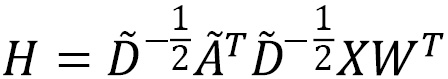

In terms of individual embeddings, this operation can be written as follows:

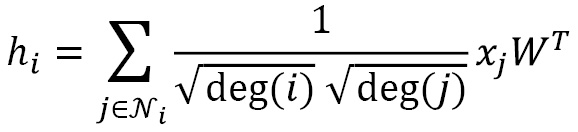

Those are the original formulas to implement a graph convolutional layer. As with our vanilla GNN layer, we can stack these layers to create a GCN. Let’s implement a GCN and verify that it performs better than our previous approaches.

### Comparing graph convolutional and graph linear layers

Compared to the vanilla GNN, the main feature of the GCN is that it considers node degrees to weigh its features. Before the real implementation, let’s analyze the node degrees in Cora dataset. This information is relevant since it is directly linked to the performance of the GCN.


From what we know about this architecture, we expect it to perform better when node degrees vary greatly. If every node has the same number of neighbors, these architectures are equivalent:


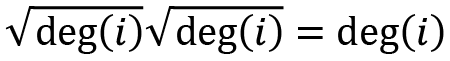

We import the `Planetoid` class from PyTorch Geometric. To visualize the node degrees, we also import `matplotlib` and two additional classes: `degree` to get the number of neighbors of each node and `Counter` to count the number of nodes for each degree

In [7]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree
from collections import Counter
import matplotlib.pyplot as plt

The Cora dataset is imported and its graph is stored in `data`

In [8]:
# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

Processing...
Done!


We compute the number of neighbors of each node in the graph

In [9]:
# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

To produce a more natural visualization, we count the number of nodes for each degree:

In [10]:
# Count the number of nodes for each degree
numbers = Counter(degrees)

Let’s plot this result using a bar plot:

<BarContainer object of 37 artists>

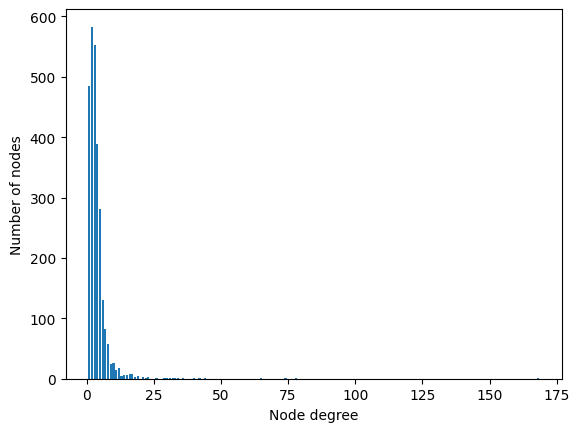

In [11]:
# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

This distribution looks exponential with a heavy tail: it ranges from 1 neighbor (485 nodes) to 168 neighbors (1 node)! This is exactly the kind of dataset where we want a normalization process to consider this disbalance.


We could build our own graph layer but, conveniently enough, PyTorch Geometric already has a predefined GCN layer. Let’s implement it on the Cora dataset first.


We import PyTorch and the GCN layer from PyTorch Geometric:

In [12]:
import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

We create a function to calculate the accuracy score

In [13]:
def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

We create a GCN class with a `__init_()` function that takes three parameters as input: the number of input dimensions, `dim_in`, the number of hidden dimensions, `dim_h`, and the number of output dimensions, `dim_out`:

In [14]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)

The `forward` method is identical, and has two GCN layers. A log `softmax` function is applied to the result for classification

In [15]:
def forward(self, x, edge_index):
    h = self.gcn1(x, edge_index)
    h = torch.relu(h)
    h = self.gcn2(h, edge_index)
    return F.log_softmax(h, dim=1)

GCN.forward = forward

The `fit()` method is the same, with the exact same parameters for the `Adam` optimizer (a learning rate of 0.1 and L2 regularization of 0.0005)

In [16]:
def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(self.parameters(),
                                  lr=0.01,
                                  weight_decay=5e-4)
    self.train()
    for epoch in range(epochs+1):
        optimizer.zero_grad()
        out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1),
                      data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if(epoch % 20 == 0):
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                              data.y[data.val_mask])
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                  f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

GCN.fit = fit

We implement the same `test()` method:

In [17]:
@torch.no_grad()
def test(self, data):
    self.eval()
    out = self(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

GCN.test = test

Let’s instantiate and train our model for **100** epochs

In [18]:
# Create the Vanilla GNN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)


Here is the output of the training

In [19]:
# Train
gcn.fit(data, epochs=100)

Epoch   0 | Train Loss: 1.932 | Train Acc: 15.71% | Val Loss: 1.94 | Val Acc: 15.20%
Epoch  20 | Train Loss: 0.099 | Train Acc: 100.00% | Val Loss: 0.75 | Val Acc: 77.80%
Epoch  40 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 0.72 | Val Acc: 77.20%
Epoch  60 | Train Loss: 0.015 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 77.80%
Epoch  80 | Train Loss: 0.017 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 77.00%
Epoch 100 | Train Loss: 0.016 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 76.40%


Finally, let’s evaluate it on the test set

In [20]:
# Test
acc = gcn.test(data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')


GCN test accuracy: 79.70%



We can attribute these high scores to the wide range of node degrees in these two datasets. By normalizing features and considering the number of neighbors of the central node and its own neighbors, the GCN gains a lot of flexibility and can work well with various types of graphs.